Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.RNMF6J_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Clases: ['Gato', 'Perro']
Ejemplos del dataset de entrenamiento:


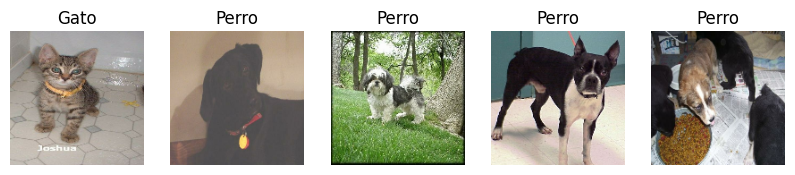

<ipython-input-1-cb466eb7e575>:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 912ms/step - accuracy: 0.4785 - loss: 0.7922 - val_accuracy: 0.7200 - val_loss: 0.5888
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step - accuracy: 0.8055 - loss: 0.4959 - val_accuracy: 0.8600 - val_loss: 0.3907
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.8978 - loss: 0.3311 - val_accuracy: 0.8800 - val_loss: 0.2861
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 798ms/step - accuracy: 0.9415 - loss: 0.2489 - val_accuracy: 0.9000 - val_loss: 0.2262
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 818ms/step - accuracy: 0.9515 - loss: 0.1829 - val_accuracy: 0.9400 - val_loss: 0.1901
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 569ms/step - accuracy: 0.9576 - loss: 0.1412 - val_accuracy: 0.9400 - val_loss: 0.1674
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 552ms/step - accuracy: 0.9625 - loss: 0.1148 - val_accuracy: 0.9400 - val_loss: 0.1516
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.9943

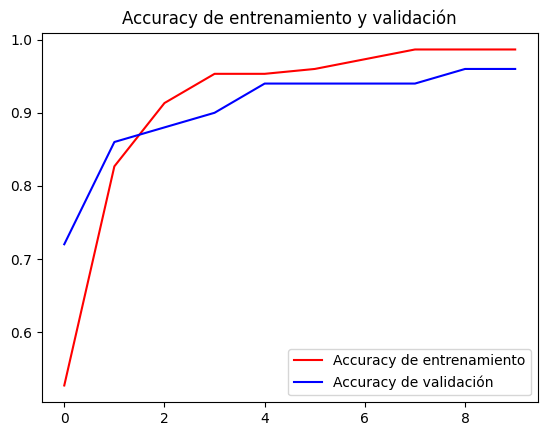

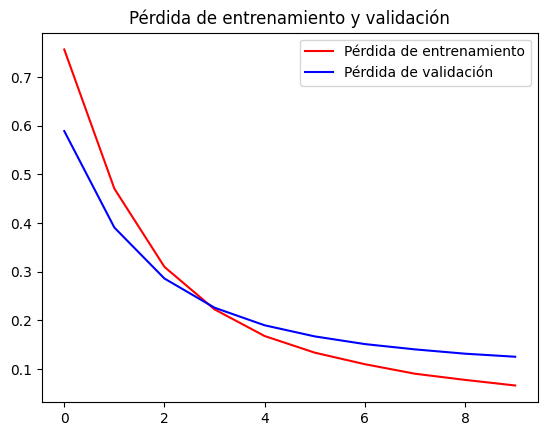

Predicciones del conjunto de validación:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<ipython-input-1-cb466eb7e575>:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(prediction[0] > 0.5)]


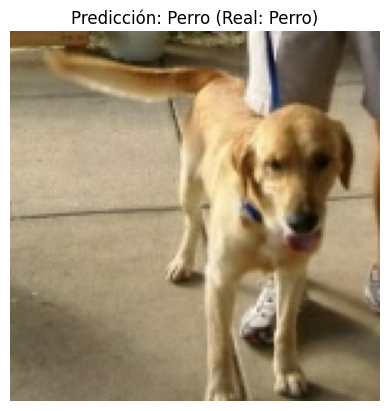

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


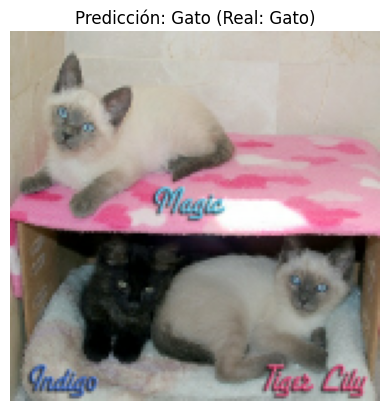

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


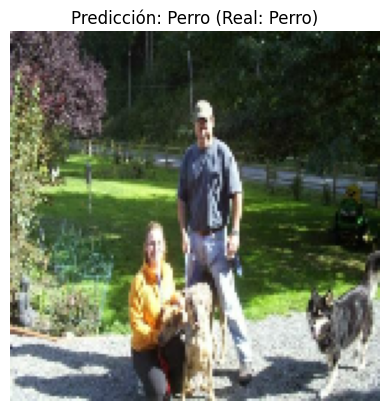

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


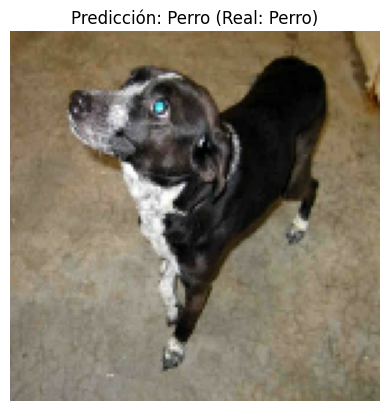

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


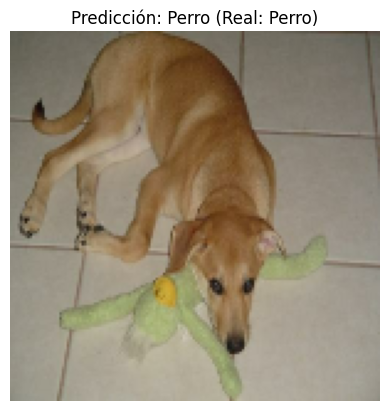

In [1]:
# Importar librerías necesarias
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Cargar el dataset Cats vs Dogs desde TensorFlow Datasets
(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # 80% para entrenamiento, 20% para validación
    with_info=True,
    as_supervised=True,  # Devuelve (imagen, etiqueta)
)

# Reducir el dataset a 200 imágenes (150 entrenamiento, 50 validación)
raw_train = raw_train.take(150)
raw_validation = raw_validation.take(50)

# Etiquetas traducidas
class_names = ["Gato", "Perro"]
print("Clases:", class_names)

# Preprocesamiento de imágenes
IMG_SIZE = (150, 150)

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Redimensionar a 150x150
    image = image / 255.0  # Normalizar a [0, 1]
    return image, label

# Aplicar preprocesamiento al dataset reducido
train = raw_train.map(preprocess_image).shuffle(1000).batch(32)
validation = raw_validation.map(preprocess_image).batch(32)

# Visualizar algunas imágenes del dataset traducido
def visualize_dataset(dataset, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0])
        plt.title(class_names[label[0].numpy()])
        plt.axis("off")
    plt.show()

print("Ejemplos del dataset de entrenamiento:")
visualize_dataset(train, class_names)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Agregar capas finales personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Promedio global para reducir dimensiones
x = Dense(128, activation='relu')(x)  # Capa densa adicional
x = Dense(1, activation='sigmoid')(x)  # Capa final para clasificación binaria

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
)

# Visualización de los resultados de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.plot(epochs_range, acc, 'r', label='Accuracy de entrenamiento')
plt.plot(epochs_range[:len(val_acc)], val_acc, 'b', label='Accuracy de validación')
plt.title('Accuracy de entrenamiento y validación')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_range, loss, 'r', label='Pérdida de entrenamiento')
plt.plot(epochs_range[:len(val_loss)], val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.legend(loc=0)
plt.show()

# Función para predecir y mostrar imágenes
def predict_and_show(model, dataset, class_names, num_images=5):
    for images, labels in dataset.take(1):
        for i in range(num_images):
            img = images[i]
            label = labels[i].numpy()

            # Hacer predicción
            img_array = tf.expand_dims(img, axis=0)  # Expandir dimensión
            prediction = model.predict(img_array)
            predicted_class = class_names[int(prediction[0] > 0.5)]

            # Mostrar la imagen con la predicción
            plt.imshow(img)
            plt.title(f"Predicción: {predicted_class} (Real: {class_names[label]})")
            plt.axis('off')
            plt.show()

# Mostrar predicciones del dataset de validación
print("Predicciones del conjunto de validación:")
predict_and_show(model, validation, class_names)
